# ResNet50 Keras model on CIFAR10 - TF2.X

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
directory = '/content/gdrive/MyDrive/weather_data/weather_images/'


In [3]:
%cd '/content/gdrive/MyDrive/weather_data/weather_images/'

/content/gdrive/MyDrive/weather_data/weather_images


In [4]:
epoch_count = 20
learn_rate = 0.00005
drop_rate = 0.25


In [5]:
import tensorflow as tf
print(tf.__version__)
!python --version

2.8.2
Python 3.7.13


In [6]:
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import PIL 
from keras.preprocessing import image
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
#from keras.applications import resnet50

%matplotlib inline
#keras.__version__ # update keras to the version >= 2.2.0

In [7]:
import pickle

pickle_in = open("/content/gdrive/MyDrive/weather_data/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/content/gdrive/MyDrive/weather_data/y.pickle","rb")
y = pickle.load(pickle_in)

In [8]:
classes=["Fog","Rain","Sand","Snow"]

In [9]:
batch_size = 32
num_classes = 4

#Split the data into training and test data (70/30 ratio)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=100)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (821, 224, 224, 3)
821 train samples
206 test samples


In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [11]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [12]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [13]:
x_train.shape

(821, 224, 224, 3)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_generator_aug():
    data_generator_aug = ImageDataGenerator(rescale=(1/255.0),
                                       rotation_range=35,
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       fill_mode='nearest',
                                       brightness_range=(0.2,0.8),
                                       shear_range=45.0,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=[0.5, 1.5])
    return data_generator_aug

In [15]:
data_generator_aug = get_generator_aug()
data_generator_aug.fit(x_train)
train_generator_aug = data_generator_aug.flow(x_train, y_train, batch_size=10, shuffle=True)

data_generator_aug_test = get_generator_aug()
data_generator_aug_test.fit(x_test)
test_generator_aug = data_generator_aug_test.flow(x_test, y_test, batch_size=10, shuffle=True)

In [16]:
data_generator = ImageDataGenerator(rescale=(1/255.0))
data_generator.fit(x_train)
img_generator = data_generator.flow(x_train, y_train, batch_size=10, shuffle=False)

In [17]:
base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(x_train.shape[1],x_train.shape[2],3))

94781440/94765736 [==============================] - 0s 0us/step


## Keras functional approach

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(drop_rate)(x)
pred = Dense(num_classes, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs=pred)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
optimizer = Adam(lr= learn_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5)]

In [22]:
%%time 
train_steps_per_epoch = train_generator_aug.n // train_generator_aug.batch_size
history = model.fit(train_generator_aug, steps_per_epoch=train_steps_per_epoch,
                  validation_data=test_generator_aug,
                  epochs=20,
                  verbose=1,
                  callbacks=callbacks)

Epoch 1/20
82/82 [==============================] - 37s 229ms/step - loss: 1.0020 - accuracy: 0.5939 - val_loss: 1.4825 - val_accuracy: 0.3107
Epoch 2/20
82/82 [==============================] - 17s 209ms/step - loss: 0.7734 - accuracy: 0.6782 - val_loss: 1.7817 - val_accuracy: 0.3107
Epoch 3/20
82/82 [==============================] - 18s 217ms/step - loss: 0.6746 - accuracy: 0.7201 - val_loss: 2.8048 - val_accuracy: 0.3107
Epoch 4/20
82/82 [==============================] - 17s 202ms/step - loss: 0.6122 - accuracy: 0.7596 - val_loss: 2.3852 - val_accuracy: 0.3107
Epoch 5/20
82/82 [==============================] - 17s 202ms/step - loss: 0.6199 - accuracy: 0.7583 - val_loss: 2.6438 - val_accuracy: 0.3107
Epoch 6/20
82/82 [==============================] - 17s 203ms/step - loss: 0.5777 - accuracy: 0.7805 - val_loss: 1.6661 - val_accuracy: 0.3107
Epoch 7/20
82/82 [==============================] - 18s 221ms/step - loss: 0.5208 - accuracy: 0.7867 - val_loss: 1.4323 - val_accuracy: 0.3398

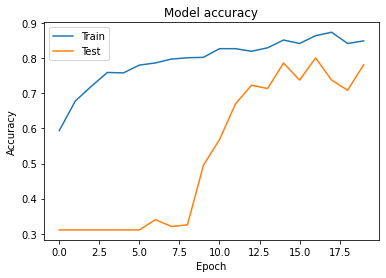

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

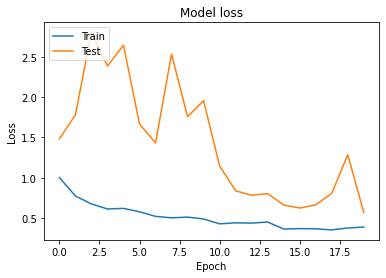

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [25]:
from array import *
def array_list(array_num):
    num_list = array_num[0].tolist() # list
    return num_list

In [26]:
img_list=["rain1.jpeg","rain2.jpeg","fog1.jpeg","fog2.jpeg","sand1.jpeg","sand2.jpeg","sand3.jpeg","snow1.jpeg","snow2.jpeg","snow3.jpeg"]

In [30]:
%%time
for i in img_list:
    img = image.load_img(i, target_size=(224, 224))
    img = image.img_to_array(img)
    #plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)

    pred_list=array_list(preds)

    new_list = [a+" "+str(round(b,2)) for a, b in zip(classes, pred_list)]
    print(i)
    print(new_list)



rain1.jpeg
['Fog 0.0', 'Rain 1.0', 'Sand 0.0', 'Snow 0.0']
rain2.jpeg
['Fog 0.0', 'Rain 1.0', 'Sand 0.0', 'Snow 0.0']
fog1.jpeg
['Fog 0.0', 'Rain 1.0', 'Sand 0.0', 'Snow 0.0']
fog2.jpeg
['Fog 0.0', 'Rain 0.0', 'Sand 1.0', 'Snow 0.0']
sand1.jpeg
['Fog 0.0', 'Rain 1.0', 'Sand 0.0', 'Snow 0.0']
sand2.jpeg
['Fog 0.0', 'Rain 1.0', 'Sand 0.0', 'Snow 0.0']
sand3.jpeg
['Fog 0.0', 'Rain 0.0', 'Sand 1.0', 'Snow 0.0']
snow1.jpeg
['Fog 1.0', 'Rain 0.0', 'Sand 0.0', 'Snow 0.0']
snow2.jpeg
['Fog 1.0', 'Rain 0.0', 'Sand 0.0', 'Snow 0.0']
snow3.jpeg
['Fog 0.0', 'Rain 1.0', 'Sand 0.0', 'Snow 0.0']
CPU times: user 584 ms, sys: 18.1 ms, total: 603 ms
Wall time: 655 ms
